In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch
import torch.nn.functional as F

In [2]:
import cv2
from collections import defaultdict

In [3]:
from ale_py import ALEInterface
ale = ALEInterface()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [4]:
from ale_py.roms import Skiing
ale.loadROM(Skiing)

Game console created:
  ROM file:  /home/makinoharafan1/code/rl-atari-skiing/rl-skiing/lib/python3.11/site-packages/AutoROM/roms/skiing.bin
  Cart Name: Skiing (1980) (Activision) [!]
  Cart MD5:  b76fbadc8ffb1f83e2ca08b6fb4d6c9f
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 1714332434


In [5]:
from typing import Any, Text

from ale_py.env import gym as ale_gym

# Patch to allow rendering Atari games.
# The AtariEnv's render method expects the mode to be in self._render_mode
# (usually initialized with env.make) instead of taking mode as a param.
_original_atari_render = ale_gym.AtariEnv.render


def atari_render(self, mode: Text = 'rgb_array') -> Any:
  original_render_mode = self._render_mode
  try:
    self._render_mode = mode
    return _original_atari_render(self)
  finally:
    self._render_mode = original_render_mode


ale_gym.AtariEnv.render = atari_render

In [41]:
env = gym.make('ALE/Skiing-v5')

In [7]:
def epsilon_greedy_policy(state, Q, epsilon, n_action):
  probs = torch.ones(n_action) * epsilon / n_action
  best_action = torch.argmax(Q[state]).item()
  probs[best_action] += 1.0 - epsilon
  return torch.multinomial(probs, 1).item()

# def epsilon_greedy_policy(observation, Q, epsilon, n_action):
#   A = np.ones(n_action, dtype=int) * epsilon / n_action
#   best_action = torch.argmax(Q[observation]).item()
#   A[best_action] += (1.0 - epsilon)
#   return A

In [20]:
def softmax_policy(state, Q, temperature):
    logits = Q[state] / temperature
    action_probs = F.softmax(logits, dim=0)
    action = torch.multinomial(action_probs, 1).item()
    return action

In [16]:
def get_pos_player(observe):
    ids = np.where(np.sum(observe == [214, 92, 92], -1) == 3)
    if len(ids[0]) == 0:
        return 0, 0  
    else:
        return int(ids[0].mean()), int(ids[1].mean())

In [17]:
def get_pos_flags(observe):
    if np.any(np.sum(observe == [184, 50, 50], -1) == 3):
        ids = np.where(np.sum(observe == [184, 50, 50], -1) == 3)
        return int(ids[0].mean()), int(ids[1].mean())
    else:
        base = 0
        ids = np.where(np.sum(observe[base:-60] == [66, 72, 200], -1) == 3)
        if len(ids[0]) == 0:
            return 0, 0  
        else:
            return int(ids[0].mean() + base), int(ids[1].mean())

In [42]:
def sarsa(env, gamma, n_episode, alpha, temperature=0.1):
  n_action = env.action_space.n
  Q = defaultdict(lambda : torch.empty(n_action))

  for episode in range(n_episode):
    env.reset()
    # state = (True, False)
    state = 0
    is_done = False
    
    while not is_done:
      # action = epsilon_greedy_policy(state, Q, epsilon, n_action)
      action = softmax_policy(state, Q, temperature)

      new_state, reward, is_done, _, _ = env.step(action)

      player_pos = get_pos_player(new_state)
      flags_pos = get_pos_flags(new_state)

      new_state = player_pos + flags_pos

      # new_state = (player_pos[1] > flags_pos[1] - 10, player_pos[1] < flags_pos[1] + 10)

      # expected_q = torch.mean(Q[new_state])
      # td_delta = reward + gamma * expected_q - Q[state][action]
      # Q[state][action] += alpha * td_delta

      td_target = reward + gamma * Q[new_state][torch.argmax(Q[new_state])]
      td_error = td_target - Q[state][action]
      Q[state][action] += alpha * td_error
      
      length_episode[episode] += 1
      total_reward_episode[episode] += reward

      state = new_state
    
    print("Episode:", episode, "Total Reward:", total_reward_episode[episode])

  policy = {}
  for state, actions in Q.items():
    policy[state] = torch.argmax(actions).item()

  return Q, policy

In [54]:
n_episode = 1250

env.reset()

length_episode = [0] * n_episode
total_reward_episode = [0] * n_episode

gamma = 1
alpha = 0.1
# epsilon = 0.1

optimal_Q, optimal_policy = sarsa(env, gamma, n_episode, alpha, temperature=0.8)

Episode: 0 Total Reward: -15087.0
Episode: 1 Total Reward: -18117.0
Episode: 2 Total Reward: -14735.0
Episode: 3 Total Reward: -15195.0
Episode: 4 Total Reward: -16066.0
Episode: 5 Total Reward: -20838.0
Episode: 6 Total Reward: -14608.0
Episode: 7 Total Reward: -15383.0
Episode: 8 Total Reward: -17418.0
Episode: 9 Total Reward: -19350.0
Episode: 10 Total Reward: -17772.0
Episode: 11 Total Reward: -17869.0
Episode: 12 Total Reward: -11611.0
Episode: 13 Total Reward: -19296.0
Episode: 14 Total Reward: -12969.0
Episode: 15 Total Reward: -14893.0
Episode: 16 Total Reward: -16588.0
Episode: 17 Total Reward: -17956.0
Episode: 18 Total Reward: -16767.0
Episode: 19 Total Reward: -12820.0
Episode: 20 Total Reward: -20931.0
Episode: 21 Total Reward: -15536.0
Episode: 22 Total Reward: -14258.0
Episode: 23 Total Reward: -20658.0
Episode: 24 Total Reward: -17002.0
Episode: 25 Total Reward: -15941.0
Episode: 26 Total Reward: -16468.0
Episode: 27 Total Reward: -15959.0
Episode: 28 Total Reward: -171

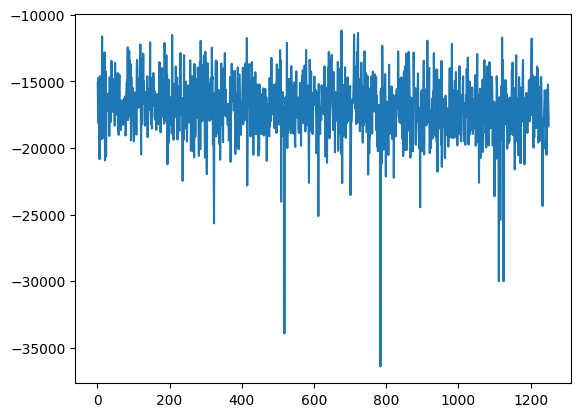

In [55]:
plt.plot(np.arange(1, n_episode + 1), total_reward_episode)
plt.show()